# How to compute the expected REINFORCE update in a network of binomial units?

We quickly recaptitulate the notation and network structure (for more details, check out the notebook "binomial_sample_size").

The input layer $\vec{p}_1$ is fully defined by the input (we assume a fixed input, when computing the expected weight update). Let us define the p-values of other layers (these are the expected activity of a neuron):

\begin{equation*}
    \vec{p}_2 = \sigma(W_1 \vec{p}_1) 
\end{equation*}

\begin{equation*}
    \vec{p}_3 = \sigma(W_2 \vec{p}_2)
\end{equation*}

However, the actual neural outputs are binomial distributed according to the following equations:

\begin{equation*}
    \vec{y}_1 = binomial(\vec{p}_1) 
\end{equation*}

\begin{equation*}
    \vec{y}_2 = binomial(\sigma(W_1 \vec{y}_1)) 
\end{equation*}

\begin{equation*}
    \vec{y}_3 = binomial(\sigma(W_2 \vec{y}_2))
\end{equation*}

We know that:

\begin{equation*}
    \vec{p}_1 == \mathbb{E}\big[\vec{y}_1\big]
\end{equation*}

In the previous notebook, we saw that we can state:

\begin{equation*}
    \vec{p}_2 == \mathbb{E}\big[\vec{y}_2\big]
\end{equation*}

and

\begin{equation*}
    \vec{p}_3 == \mathbb{E}\big[\vec{y}_3\big]
\end{equation*}


As before, we are interested in cases where the sigmoid acts mostly in its linear regime (by appropriate choices of network weights). It is obvious, that we would want a network to find weights such that the sigmoid acts linearly to increase the entropy.

In this notebook, we are interested in the expected weight update $\mathbb{E}\big[ \Delta w \big]$ by considering the update rule from the REINFORCE framework:

\begin{equation*}
    \Delta w_{ij} = \alpha (r-r_b) (y_j-p_j) x_i
\end{equation*}

## Local Expectations

At first we consider a sub-expression of the update rule, namely $(y-p) x$. It is clear, that when computing $\mathbb{E}\big[ \Delta w \big]$, the terms $(r-r_b)$ and $(y-p) x$ may not be considered independently. But while $r$ is conditioned on $(y-p) x$, the other direction does not hold true. I.e., we can compute $\mathbb{E}\big[ (y-p) x \big]$ independent of $r$ as a first step.

\begin{align}
    & \mathbb{E}\big[ (y-p) x \big] \\
    \Leftrightarrow & \mathbb{E}\big[ y \cdot x \big] - \mathbb{E}\big[ p \cdot x \big]
\end{align}

Now that we split the expectation into two parts, we can consider them individually:

\begin{align}
    & \mathbb{E}\big[ y \cdot x \big] \\
    \Leftrightarrow & p(x=1,y=1) \\
    \Leftrightarrow & p(x=1) p(y=1|x=1) \\
\end{align}

We already know how to compute the probability $p(x=1) = p_x$. The conditional probability $p(y=1|x=1)$ can be computed by computing $p(y=1) = p_y$ in a network where the specific connection from $x$ is held fix (clamped to 1).

For the second term it holds, that (we use subindices, to be not confused with the probability function)

\begin{align}
    & \mathbb{E}\big[ p_j \cdot x_i \big] \\
    \Leftrightarrow & \mathbb{E}\big[ p_j(\vec{x}) \cdot x_i \big] \\
    \Leftrightarrow & \mathbb{E}\big[ p_j(\vec{x}_{|x_i = 1})\big] \cdot p(x_i=1) \\
    \Leftrightarrow & p(x_i=1) p(y_j=1|x_i=1) \\
\end{align}

$\vec{x}_{|x_i = 1}$ is the activation of layer $x$ with the i-th element clamped to 1. Note, that $p_j$ is computed from the activity in layer $\vec{x}$ (and the weights, which are constant while we are computing the expectation).

That implies, that without the modulation of an denpendent reward, the weight update should be zero. This is sensible. because if a connection $x \rightarrow y$ is independent of the reward, there is no reason to change its weight.

\begin{align}
    & \mathbb{E}\big[ (y-p) x \big] = 0
\end{align}

## Global Reward

Now we can move to cases, where we incorporate the reward such that we can calculate the actual expected value of the weight update.

\begin{align}
    \frac{1}{\alpha} \mathbb{E}\big[ \Delta w \big] = & \mathbb{E}\big[ (r-r_b) (y-p) x \big] \\
    \Leftrightarrow & \mathbb{E}\big[ r \cdot (y-p) \cdot x \big] - \mathbb{E}\big[ r_b \cdot (y-p) \cdot x \big] \\
    \Leftrightarrow & \mathbb{E}\big[ r \cdot (y-p) \cdot x \big] - r_b \underbrace{\mathbb{E}\big[ (y-p) \cdot x \big]}_{0} \\
    \Leftrightarrow & \mathbb{E}\big[ r \cdot y \cdot x \big] - \mathbb{E}\big[ r \cdot p \cdot x \big]
\end{align}

So, the baseline doesn't matter anymore when considering the expectation. Therefore, we directly ignore it in the calculations below.

### Two-Neuron Network

At first, let us consider the very simple case, when we have one neuron $x_i$ projecting onto $y_j$. The input to the network is $p_{x,i}$ and the p-value of the output neuron is $p_{y,j} = \sigma (\vec{w_j}^T \vec{x})$, or in our special case $p_{y,j} = \sigma (w_{ij} x_i)$, $\vec{w_j}$ are the weight of the connections going into $y_j$.

\begin{equation*}
    x_i = bin(p_{x,i}) \qquad \xrightarrow{w_{ij}} \qquad y_j = bin(p_{y,j})
\end{equation*}

We are interested in autoencoding, therefore we use a MSE reconstruction loss. Note, that a perfect reconstruction is not possible as $p_{x,i} \in [0,1]$ but $y_j \in \{0,1\}$. We could also use $p_{y,j}$ to compute the loss. Anyway, we decide here to use $y$.

\begin{equation*}
    L = (y_j - p_{x,i})^2 = -r
\end{equation*}

Note, later on we might be interested in more complex rewards (e.g., amplified by regularizers). If we get valuable insides from this simple cases, we can still repeat the process with more complicated rewards. As regularizers are additive in the loss formulation, we can consider this cases completely independent from the reconstruction loss (the expectation splits into the additive terms in the loss).

We can now plug this reward into the expectation we want to compute.

\begin{align}
    & \mathbb{E}\big[ r (y_j-p_{y,j}) x_i \big] \\
    \Leftrightarrow & \mathbb{E}\big[ - (y_j - p_{x,i})^2 (y_j-p_{y,j}) x_i \big] \\
    \Leftrightarrow & \mathbb{E}\big[ - (y_j^2 - 2 y_j p_{x,i} + p_{x,i}^2) (y_j-p_{y,j}) x_i \big] \\
    \Leftrightarrow & \mathbb{E}\big[ - y_j^2 (y_j-p_{y,j}) x_i \big] + \mathbb{E}\big[ 2 y_j p_{x,i} (y_j-p_{y,j}) x_i \big] - \mathbb{E}\big[ p_{x,i}^2 (y_j-p_{y,j}) x_i \big] \\
    \Leftrightarrow & \mathbb{E}\big[ y_j^2 p_{y,j} x_i - y_j^3 x_i \big] + 2 p_{x,i} \mathbb{E}\big[ y_j^2 x_i - y_j p_{y,j} x_i \big] - p_{x,i}^2 \underbrace{\mathbb{E}\big[(y_j-p_{y,j}) x_i \big]}_{0} \\
\end{align}

Don't forget that $p_{x,i}$ is a constant, i.e., we compute the expectation for the current input. Now, we use the following identity:

\begin{equation*}
    y_j^k = y_j \qquad \text{if } k \geq 1
\end{equation*}

This leads to:

\begin{align}
    & \mathbb{E}\big[ y_j p_{y,j} x_i - y_j x_i \big] + 2 p_{x,i} \mathbb{E}\big[ y_j x_i - y_j p_{y,j} x_i \big] \\
    \Leftrightarrow & \mathbb{E}\big[ y_j p_{y,j} x_i - y_j x_i \big] - 2 p_{x,i} \mathbb{E}\big[ y_j p_{y,j} x_i - y_j x_i \big] \\
    \Leftrightarrow & (1- 2 p_{x,i}) \mathbb{E}\big[ y_j p_{y,j} x_i - y_j x_i \big] \\
    \Leftrightarrow & (1- 2 p_{x,i}) \Big[ \mathbb{E}\big[ y_j p_{y,j} x_i \big] -  \mathbb{E}\big[ y_j x_i \big]  \Big]\\
\end{align}

We already saw that

\begin{equation*}
    \mathbb{E}\big[ y_j x_i \big]  = p_{x,i} \cdot p(y_j = 1 | x_i = 1) = p_{x,i} \cdot \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big] 
\end{equation*}

For the second term, it holds that

\begin{equation*}
    \mathbb{E}\big[ y_j p_{y,j} x_i \big]  = p_{x,i} \cdot p(y_j = 1 | x_i = 1)^2 = p_{x,i} \cdot \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big]^2 
\end{equation*}

Therefore, the expected weight update in this setting can be written as:

\begin{align}
    \frac{1}{\alpha} \mathbb{E}\big[ \Delta w \big] = & \mathbb{E}\big[ r (y_j-p_{y,j}) x_i \big] \\
    = & p_{x,i} \cdot (1- 2 p_{x,i}) \Big[ \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big]^2 - \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big] \Big]\\
\end{align}

Let's look at the terms in this learning rule separately.

\begin{equation*}
  (1- 2 p_{x,i})=\begin{cases}
               < 0 \qquad \text{, if } p_{x,i} > 0.5 \\
               > 0 \qquad \text{, if } p_{x,i} < 0.5 \\
               = 0 \qquad \text{, if } p_{x,i} = 0.5
            \end{cases}
\end{equation*}

This tells us, that input at chance level does not have any preferred output, which is sensible.

\begin{equation*}
  \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big]^2 - \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big]=\begin{cases}
               = 0 \qquad \text{, if } \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big] \in \{0,1\} \\
               < 0 \qquad \text{, else}
            \end{cases}
\end{equation*}

This is is not an optimal situation. First of all, the sigmoid squashes the value inside the expectation to 0 or 1. Second, in a network with a single input unit $x_i$, which is clamped to 1, the expectation will simply be $\sigma(w_{ij})$, meaning that an inproper weight initialization can prevent the system from learning. On the other hand, the sigmoid prevents the value inside the expectation from actually becoming 0 or 1 (theoretically), the value only converges relatively fast to this values. Therefore, learning will never be stopped by this term, it only becomes very slow.

This emphasizes again, why it is very important in this framework to have a **proper weight initialization**. Additionally, small learning rates or mini-batches seem to be necessary, otherwise the sigmoid leaves the linear regime too fast.

The third term in the expected weight update is again sensible, meaning there will be no weight update only if $p_{x,i} = 0$. If $p_{x,i} = 0$, then $x_i$ is certainly 0 and the weight $w_{ij}$ does not matter, as it transmits no information.

Altogether, we get

\begin{equation*}
  \mathbb{E}\big[ \Delta w \big]=\begin{cases}
               > 0 \qquad \text{, if } p_{x,i} > 0.5 \\
               < 0 \qquad \text{, if } 0 < p_{x,i} < 0.5 \\
               = 0 \qquad \text{, if } p_{x,i} \in \{0, 0.5\}
            \end{cases}
\end{equation*}

How does this rule generalize to networks with multiple input and output neurons. As you may have noticed, the equations do not assume a single neuron input layer, i.e., they hold for and arbitrarily sized input layer. However, the loss is not defined for an $n$-to-$1$ network. But n-to-n fully connected 2-layer autoencoders make no sense. Therefore, we consider next the case of a general target.

### 2-Layer Network

We still use the MSE loss, but with arbitrary targets $\vec{t}$:

\begin{equation*}
    L = \sum_j (y_j - t_j)^2 = -r
\end{equation*}

In an n-to-1 network, we can simply dapt the above learning rule to get

\begin{align}
    \frac{1}{\alpha} \mathbb{E}\big[ \Delta w \big] = & \mathbb{E}\big[ r (y_j-p_{y,j}) x_i \big] \\
    = & p_{x,i} \cdot (1- 2 t_j) \Big[ \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big]^2 - \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big] \Big]\\
\end{align}

For more than 1 output neuron, we need to incoporate other loss terms.

\begin{align}
    & \mathbb{E}\big[ r (y_j-p_{y,j}) x_i \big] \\
    = & \mathbb{E}\big[ - \sum_k(y_k - t_k)^2 (y_j-p_{y,j}) x_i \big] \\
    = & \mathbb{E}\big[ - (y_j - t_j)^2 (y_j-p_{y,j}) x_i \big] + \mathbb{E}\big[ - \sum_{k \neq j}(y_k - t_k)^2 (y_j-p_{y,j}) x_i \big] \\
\end{align}

The first term in this equation is explained by the above weight update. Thus, we next have to consider terms such as

\begin{align}
    & \mathbb{E}\big[ - (y_k - t_k)^2 (y_j-p_{y,j}) x_i \big] \qquad k \neq j \\
    = & \mathbb{E}\big[ - (y_k^2 - 2 y_k t_k + t_k^2) (y_j-p_{y,j}) x_i \big] \\
    = & \mathbb{E}\big[ - y_k^2 (y_j-p_{y,j}) x_i \big] + \mathbb{E}\big[ 2 y_k t_k (y_j-p_{y,j}) x_i \big] - \mathbb{E}\big[ t_k^2 (y_j-p_{y,j}) x_i \big] \\
    = & \mathbb{E}\big[ y_k^2 p_{y,j} x_i - y_k^2 y_j x_i \big] + 2 t_k \mathbb{E}\big[ y_k y_j x_i - y_k p_{y,j} x_i \big] - t_k^2 \underbrace{\mathbb{E}\big[(y_j-p_{y,j}) x_i \big]}_{0} \\
    = & \mathbb{E}\big[ y_k p_{y,j} x_i - y_k y_j x_i \big] + 2 t_k \mathbb{E}\big[ y_k y_j x_i - y_k p_{y,j} x_i \big] \\
    = & \mathbb{E}\big[ y_k p_{y,j} x_i - y_k y_j x_i \big] - 2 t_k \mathbb{E}\big[ y_k p_{y,j} x_i - y_k y_j x_i \big] \\
    = & (1- 2 t_k) \mathbb{E}\big[ y_k p_{y,j} x_i - y_k y_j x_i \big] \\
    = & (1- 2 t_k) \Big[ \mathbb{E}\big[ y_k p_{y,j} x_i \big] -  \mathbb{E}\big[ y_k y_j x_i \big]  \Big]\\
\end{align}

Let's consider these terms independently:

\begin{align}
    & \mathbb{E}\big[ y_k p_{y,j} x_i \big] \\
    = & p_{x,i} p(y_j = 1| x_i = 1) p(y_k = 1| x_i = 1) \\
    = & p_{x,i} \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big] \mathbb{E}\big[ \sigma (\vec{w_k}^T \vec{x}_{|x_i = 1}) \big]
\end{align}

Note, we assumed here, that the expected values of $y_k$ and $p_{y,j}$ are independent. We can only empirically test if this assumption is valid.

Now, we can look at the second term:

\begin{align}
    & \mathbb{E}\big[ y_k y_j x_i \big] \\
    = & p_{x,i} p(y_j = 1, y_k = 1| x_i = 1)\\
\end{align}

The term $p(y_j = 1, y_k = 1| x_i = 1)$ is clearly not conditional independent, as in general for more than one input neuron it holds that 

\begin{equation*}
    p(y_k = 1| x_i = 1) < p(y_k = 1| x_i = 1, y_j = 1)
\end{equation*}

The conditional probability $p(y_j = 1, y_k = 1| x_i = 1)$ is hard to estimate. We would need to enumerate over all possible input vectors $\vec{\hat{x}}_{|x_i = 1}$, in which $x_i = 1$, i.e., we need to marginalize $\vec{x}$ to make $y_j$ and $y_k$ conditionl independent.

\begin{align}
    & p(y_j = 1, y_k = 1| x_i = 1)\\
    = & \sum_{\vec{\hat{x}}_{|x_i = 1}} p(\vec{\hat{x}}_{|x_i = 1}) p(y_j = 1| \vec{\hat{x}}_{|x_i = 1}) p(y_k = 1| \vec{\hat{x}}_{|x_i = 1})\\
\end{align}

As $\vec{x}$ is the input vector, its individual components are independent from each other, so we can write the joint probability as:

\begin{equation*}
    p(\vec{\hat{x}}_{|x_i = 1}) = \prod_l p(\vec{\hat{x}}_{|x_i = 1}^l)
\end{equation*}

with

\begin{equation*}
  p(\vec{\hat{x}}_{|x_i = 1}^l)=\begin{cases}
               p_{x,l} \qquad \text{, if } \vec{\hat{x}}_{|x_i = 1}^l = 1 \\
               1 - p_{x,l} \qquad \text{, if } \vec{\hat{x}}_{|x_i = 1}^l = 0 \\
               p_{x,i} \qquad \text{, if } i = l
            \end{cases}
\end{equation*}

Recall, that the following holds true

\begin{equation*}
  (1- 2 p_{x,i})=\begin{cases}
               < 0 \qquad \text{, if } p_{x,i} > 0.5 \\
               > 0 \qquad \text{, if } p_{x,i} < 0.5 \\
               = 0 \qquad \text{, if } p_{x,i} = 0.5
            \end{cases}
\end{equation*}

Note, if $\vec{x}$ is fully defined, then $p(y_j = 1| \vec{\hat{x}}_{|x_i = 1}) = \sigma (\vec{w_j}^T \vec{\hat{x}}_{|x_i = 1})$.

Now, we can put everything together to get:

\begin{align}
    \frac{1}{\alpha} \mathbb{E}\big[ \Delta w \big] = & \mathbb{E}\big[ r (y_j-p_{y,j}) x_i \big] \\
    = & \mathbb{E}\big[ - (y_j - t_j)^2 (y_j-p_{y,j}) x_i \big] + \mathbb{E}\big[ - \sum_{k \neq j}(y_k - t_k)^2 (y_j-p_{y,j}) x_i \big] \\
    = & p_{x,i} \cdot (1- 2 t_j) \Big[ \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big]^2 - \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big] \Big] + \sum_{k \neq j} (1- 2 t_k) \Big[ \mathbb{E}\big[ y_k p_{y,j} x_i \big] -  \mathbb{E}\big[ y_k y_j x_i \big]  \Big]\\
\end{align}

with

\begin{equation*}
    \mathbb{E}\big[ y_k p_{y,j} x_i \big] = p_{x,i} \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big] \mathbb{E}\big[ \sigma (\vec{w_k}^T \vec{x}_{|x_i = 1}) \big]
\end{equation*}

and

\begin{equation*}
    \mathbb{E}\big[ y_k y_j x_i \big] = p_{x,i} \sum_{\vec{\hat{x}}_{|x_i = 1}} \prod_l p(\vec{\hat{x}}_{|x_i = 1}^l) \sigma (\vec{w_j}^T \vec{\hat{x}}_{|x_i = 1}) \sigma (\vec{w_k}^T \vec{\hat{x}}_{|x_i = 1})
\end{equation*}

### General networks

As can be seen above, the expected value of a 2-layer network is already consisting of exponential many terms (the marginalization of $\vec{x}$). However, this weight update rule does not even hold for a general network, as the components of $p(\vec{\hat{x}}_{|x_i = 1})$ are not independent if $x$ is not the input layer. Hence, we would need to marginalize over the whole network, which is even more infeasible.

Therefore, we ignore this case for now, as it is not a valid alternative approach to sampling anymore to learn within the REINFORCE framework.

But, we may have to come back to their calculation to evaluate sampling sizes. At the moment, we assume that sampling in the last layer must be harder than sampling in early layers due to the stochasticity of the network. However, that intuition might not hold in general. Instead, it might be, that it is harder for an neuron in the early layers to estimate its influence on the global reward, which may result in larger sampling sizes needed for early layers. Without numerical experiments, this claim cannot be falsified.

# Experiments

Now we perform numerical experiments to assert that the above calculations are correct. 

## Local Expectations

In this experiments we aim to assert that $\mathbb{E}\big[ (y-p) x \big] = 0$. We therefore construct networks with a single output neuron. The first neuron in the previous layer will serve as our neuron $x$.

In [1]:
import numpy as np
import time

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
def sigmoid(x):
    """Compute the sigmoid function."""
    return 1./(1.+np.exp(-x))

def mse_reward(y, t):
    """A mean-squared error reward function, that
    compares output activation with a target.
    
    Args:
        y: Binary vector.
        t: Binary vector.
        
    Returns:
        sum_i (y_i - t_i)^2
    """
    return -np.sum((y-t)**2)

def zero_target(p_in, W, t):
    """An example target function. Targets are used as a convergence criteria for
    expected values. Therefore, they always need to cooccur with and estimation
    function. This function simply returns 0 as target.
    
    Args:
        p_in: The p_values (firing probabilities) of input neurons.
        W: List of weight matrices, that connect consecutive layers.
        t: The target output values.
        
    Returns:
        0        
    """
    return 0

def local_estimation(p_values, activities, W, t):
    """An example estimation function. Estimation functions are used to approximate
    an expected value. The return value depends on the current (stochastic) network
    activity. Sampling over estimation should lead to the target expected value.
    
    For instance E[(y-p)*x] = 0, but the current estimate is simply (y-p)*x.
    
    Args:
        p_values: The list of layer-wise p-values (firing probabilities).
            The first entry are the input p-values.
        activities: A list of activity vectors (representing the
            output of binomial units given the corresponding 
            p-values).
        W: List of weight matrices, that connect consecutive layers.
        t: The target output values.
        
    Returns:
        (y_0-p_y_0)*x_0        
    """
    return (activities[-1][0]-p_values[-1][0])*activities[-2][0]

def ae_labels(p_x, out_size):
    """Depending on the input, determine what should be the output of 
    the network. In this case, we use autoencoder labels, i.e., the 
    input is returned by this function.
    
    Args:
        p_x: The p_values (firing probabilities) of input neurons.
        out_size: Size of the output layer.
        
    Returns:
        p_x    
    """
    assert(p_x.size == out_size)
    return p_x

def linear_labels(p_x, out_size):
    """Separate the input space by a hyperplane.
    
    Args:
        p_x: The p_values (firing probabilities) of input neurons.
        out_size: Size of the output layer.
        
    Returns:
        Vector of zeros, if in first half space.
        Vector of ones, else.
    """
    w = np.ones(p_x.size)
    w /= np.linalg.norm(w)

    b = np.linalg.norm(np.ones(p_x.size) * 0.5)
    
    if (np.dot(w,p_x) - b) < 0:
        return np.zeros(out_size)
    
    return np.ones(out_size)

def sample_size_needed(trial, p_in, W, target, estimation, labels, eps=0.001):
    """The determine the number of forward passes that would be needed for the given
    network and input to actually approximate the expected value of an expression, 
    whose value can be estimated and the actual target can be computed.
    
    Args:
        trial: Just an integer that can be used to indicate progress in an outer loop.
        p_in: The p_values (firing probabilities) of input neurons.
        W: List of weight matrices, that connect consecutive layers.
        target: See method 'mean_sample_size'.
        estimation: See method 'mean_sample_size'.
        labels: See method 'mean_sample_size'.
        eps: See method 'mean_sample_size'.
            
    Returns: 
        The number of forward sweeps needed in this setting. Note, the network is
        stochastic, hence this function should be called many times with the same
        parameters to get an estimate of the actual number of trials needed.
    """
    # Number of forward sweeps through the network so far.
    n = 0
    # Sum of estimations for all trials.
    # I.e., the expected value is sum_outputs/n.
    sum_values = 0
    
    t = labels(p_in, W[-1].shape[0])
    tar = target(p_in, W, t)
    
    while True:
        n += 1

        # Layer-wise p-values and activations.
        p_values = [p_in]
        activations = []
        # Response of input neurons.
        activations.append(p_in > np.random.rand(p_in.size))

        # Hidden forward sweeps.
        for l in range(len(W)):
            p_l = sigmoid(np.dot(W[l], activations[l]))
            p_values.append(p_l)
            activations.append(p_l > np.random.rand(p_l.size))


        sum_values += estimation(p_values, activations, W, t)
        
        if abs(sum_values/float(n) - tar) < eps:
            return n
        
        # Avoid infinite loops
        if n > 100000:
            print('    No convergence in trial %d; current error: %e' % \
                    (trial, abs(sum_values/float(n) - tar)))
            return n

def mean_sample_size(N=1000, M=10, n_neurons=[1,1], target=zero_target, \
                          estimation=local_estimation, labels=ae_labels, eps=0.001):
    """Estimate the number of forward sweeps needed through a network of stochastic
    binomial units to approximate the expected value defined by the estimation function
    within an epsilon interval.
    
    Note, we only consider two layer networs.
    
    Args:
        N: The number of different input/weight configurations to test.
        M: How often, the same input/weight matrices should be probed.
            Note, the actual number of trials is N*M. N times new parameters
            for the function 'sample_size_needed' are generated. This function
            is then M times called with this parameters.
        n_neurons: A list of integers, representing the number of neurons in each
            layer.
        target: A function, that determines the target expected value to
            estimate.
        estimation: A function, that gives an estimtion of the expected value
            to compute.
        labels: A function, that returns the target output given the current
            network input.
        eps: The convergence criteria (i.e., out estimate must be within an eps interval
            of the actual target).
    """
    n_layers = len(n_neurons)
    assert(n_layers > 1)
    
    start_time = time.time()
    
    print('Number of trials to process: %d.' % (N*M))
    
    # For all parameter configurations tested, store the mean and std sample size
    # returned by 'sample_size_needed'.
    num_forward_passes_needed = np.zeros((N,2))

    for i in range(N):
        # input neurons
        p_in = np.random.rand(n_neurons[0])

        # Weights of consecutive layers.
        W = []
        for l in range(1,n_layers):
            W.append(np.random.rand(n_neurons[l], n_neurons[l-1]) - 0.5)

        
        # We might want that the norm of W*p is small, such that the sigmoid does not
        # necessarily squash them to zero or one. This might distort the behavior 
        # of the actual neural net?
        p_l = np.copy(p_in)
        for l in range(n_layers-2):
            # What would be the expected p value in this layer, if no sigmoid would be applied?
            # (Note, that we want this value to be in the linear range of the sigmoid, such that 
            # the sigmoid has little to no effect.).
            p_l_temp = np.dot(W[l], p_l)

            w_norm = np.linalg.norm(p_l_temp)
            if w_norm > 1:
                W[l] /= w_norm

            # This value matches the expected p value of the current layer, which can then be used
            # as input to the next layer.
            p_l = sigmoid(np.dot(W[l], p_l))
            

        sample_sizes = np.zeros(M)
        for j in range(M):
            sample_sizes[j] = sample_size_needed(i*M+j, p_in, W, target, \
                                                 estimation, labels, eps)
            
            if i > 0 and (i*M+j) % 1000 == 0:
                print('Trial %d/%d processed (elapsed time: %.2f sec).' % \
                     (i*M+j, N*M, time.time() - start_time))
                
        num_forward_passes_needed[i,0] = sample_sizes.mean()
        num_forward_passes_needed[i,1] = sample_sizes.std()
        
    print('Elapsed time: %.2f sec.' % (time.time() - start_time))
    printmd('**Mean** (std) **sample size** needed accross trials to converge: **%.2f** (%.2f).' % \
          (num_forward_passes_needed[:,0].mean(), num_forward_passes_needed[:,0].std())) 
    print('Mean (std) of the standard deviation within trials: %.2f (%.2f).' % \
          (num_forward_passes_needed[:,1].mean(), num_forward_passes_needed[:,1].std())) 

### Experiments on a 2-neuron network.

These experiments are conducted on a two-neuron network, i.e. we have one input neuron projecting onto one output neuron.

Note, that we can relatively fast assert that $\mathbb{E}\big[ (y-p) x \big] = 0$.

In [2]:
mean_sample_size(n_neurons=[1,1], target=zero_target, estimation=local_estimation, labels=ae_labels, eps=0.1)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 0.09 sec).
Trial 2000/10000 processed (elapsed time: 0.15 sec).
Trial 3000/10000 processed (elapsed time: 0.21 sec).
Trial 4000/10000 processed (elapsed time: 0.27 sec).
Trial 5000/10000 processed (elapsed time: 0.32 sec).
Trial 6000/10000 processed (elapsed time: 0.37 sec).
Trial 7000/10000 processed (elapsed time: 0.43 sec).
Trial 8000/10000 processed (elapsed time: 0.49 sec).
Trial 9000/10000 processed (elapsed time: 0.55 sec).
Elapsed time: 0.60 sec.


**Mean** (std) **sample size** needed accross trials to converge: **4.07** (3.00).

Mean (std) of the standard deviation within trials: 4.71 (5.15).


In [3]:
mean_sample_size(n_neurons=[1,1], target=zero_target, estimation=local_estimation, labels=ae_labels, eps=0.01)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 0.87 sec).
Trial 2000/10000 processed (elapsed time: 1.53 sec).
Trial 3000/10000 processed (elapsed time: 2.13 sec).
Trial 4000/10000 processed (elapsed time: 2.97 sec).
Trial 5000/10000 processed (elapsed time: 3.85 sec).
Trial 6000/10000 processed (elapsed time: 4.65 sec).
Trial 7000/10000 processed (elapsed time: 5.42 sec).
Trial 8000/10000 processed (elapsed time: 6.16 sec).
Trial 9000/10000 processed (elapsed time: 6.64 sec).
Elapsed time: 7.33 sec.


**Mean** (std) **sample size** needed accross trials to converge: **58.95** (106.09).

Mean (std) of the standard deviation within trials: 118.37 (247.39).


In [4]:
mean_sample_size(n_neurons=[1,1], target=zero_target, estimation=local_estimation, labels=ae_labels, eps=0.001)

Number of trials to process: 10000.
    No convergence in trial 512; current error: 2.750150e-03
    No convergence in trial 878; current error: 4.221153e-03
Trial 1000/10000 processed (elapsed time: 10.76 sec).
    No convergence in trial 1141; current error: 1.447786e-03
    No convergence in trial 1292; current error: 1.679943e-03
    No convergence in trial 1714; current error: 1.486912e-03
    No convergence in trial 1949; current error: 1.934082e-03
Trial 2000/10000 processed (elapsed time: 23.15 sec).
    No convergence in trial 2416; current error: 2.188862e-03
    No convergence in trial 2959; current error: 1.526304e-03
Trial 3000/10000 processed (elapsed time: 37.74 sec).
    No convergence in trial 3138; current error: 2.961316e-03
    No convergence in trial 3662; current error: 2.538812e-03
    No convergence in trial 3689; current error: 1.863119e-03
    No convergence in trial 3907; current error: 2.304858e-03
Trial 4000/10000 processed (elapsed time: 54.62 sec).
    No

**Mean** (std) **sample size** needed accross trials to converge: **987.35** (2237.98).

Mean (std) of the standard deviation within trials: 2447.11 (5680.95).


### General Networks

Here we consider general networks with multiple layers and multiple neurons.

It seems that network width and depth have no effect on the sample size needed to approximate the expected value. Only the tolerance $\varepsilon$ does.

In [5]:
mean_sample_size(n_neurons=[10,1], target=zero_target, estimation=local_estimation, labels=linear_labels, eps=0.1)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 0.09 sec).
Trial 2000/10000 processed (elapsed time: 0.19 sec).
Trial 3000/10000 processed (elapsed time: 0.28 sec).
Trial 4000/10000 processed (elapsed time: 0.37 sec).
Trial 5000/10000 processed (elapsed time: 0.46 sec).
Trial 6000/10000 processed (elapsed time: 0.55 sec).
Trial 7000/10000 processed (elapsed time: 0.63 sec).
Trial 8000/10000 processed (elapsed time: 0.72 sec).
Trial 9000/10000 processed (elapsed time: 0.81 sec).
Elapsed time: 0.89 sec.


**Mean** (std) **sample size** needed accross trials to converge: **4.38** (3.12).

Mean (std) of the standard deviation within trials: 4.82 (5.24).


In [6]:
mean_sample_size(n_neurons=[10,1], target=zero_target, estimation=local_estimation, labels=linear_labels, eps=0.01)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 0.77 sec).
Trial 2000/10000 processed (elapsed time: 1.49 sec).
Trial 3000/10000 processed (elapsed time: 2.14 sec).
Trial 4000/10000 processed (elapsed time: 3.21 sec).
Trial 5000/10000 processed (elapsed time: 3.73 sec).
Trial 6000/10000 processed (elapsed time: 4.31 sec).
Trial 7000/10000 processed (elapsed time: 5.01 sec).
Trial 8000/10000 processed (elapsed time: 5.73 sec).
Trial 9000/10000 processed (elapsed time: 6.38 sec).
Elapsed time: 7.15 sec.


**Mean** (std) **sample size** needed accross trials to converge: **54.98** (113.39).

Mean (std) of the standard deviation within trials: 118.41 (294.64).


In [7]:
mean_sample_size(n_neurons=[10,10,1], target=zero_target, estimation=local_estimation, labels=linear_labels, eps=0.1)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 0.11 sec).
Trial 2000/10000 processed (elapsed time: 0.21 sec).
Trial 3000/10000 processed (elapsed time: 0.32 sec).
Trial 4000/10000 processed (elapsed time: 0.45 sec).
Trial 5000/10000 processed (elapsed time: 0.55 sec).
Trial 6000/10000 processed (elapsed time: 0.66 sec).
Trial 7000/10000 processed (elapsed time: 0.76 sec).
Trial 8000/10000 processed (elapsed time: 0.87 sec).
Trial 9000/10000 processed (elapsed time: 0.97 sec).
Elapsed time: 1.07 sec.


**Mean** (std) **sample size** needed accross trials to converge: **4.22** (2.26).

Mean (std) of the standard deviation within trials: 5.04 (4.08).


In [8]:
mean_sample_size(n_neurons=[10,10,1], target=zero_target, estimation=local_estimation, labels=linear_labels, eps=0.01)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 1.10 sec).
Trial 2000/10000 processed (elapsed time: 2.38 sec).
Trial 3000/10000 processed (elapsed time: 3.47 sec).
Trial 4000/10000 processed (elapsed time: 4.51 sec).
Trial 5000/10000 processed (elapsed time: 5.28 sec).
Trial 6000/10000 processed (elapsed time: 6.38 sec).
Trial 7000/10000 processed (elapsed time: 7.56 sec).
Trial 8000/10000 processed (elapsed time: 8.77 sec).
Trial 9000/10000 processed (elapsed time: 9.63 sec).
Elapsed time: 10.64 sec.


**Mean** (std) **sample size** needed accross trials to converge: **57.20** (83.54).

Mean (std) of the standard deviation within trials: 124.43 (211.70).


In [9]:
mean_sample_size(n_neurons=[10]*9 + [1], target=zero_target, estimation=local_estimation, labels=linear_labels, eps=0.01)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 2.25 sec).
Trial 2000/10000 processed (elapsed time: 4.77 sec).
Trial 3000/10000 processed (elapsed time: 7.43 sec).
Trial 4000/10000 processed (elapsed time: 10.67 sec).
Trial 5000/10000 processed (elapsed time: 13.64 sec).
Trial 6000/10000 processed (elapsed time: 16.46 sec).
Trial 7000/10000 processed (elapsed time: 19.05 sec).
Trial 8000/10000 processed (elapsed time: 21.24 sec).
Trial 9000/10000 processed (elapsed time: 23.96 sec).
Elapsed time: 27.15 sec.


**Mean** (std) **sample size** needed accross trials to converge: **48.50** (73.62).

Mean (std) of the standard deviation within trials: 102.17 (187.27).


In [10]:
mean_sample_size(n_neurons=[100,100,1], target=zero_target, estimation=local_estimation, labels=linear_labels, eps=0.01)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 1.71 sec).
Trial 2000/10000 processed (elapsed time: 3.51 sec).
Trial 3000/10000 processed (elapsed time: 5.12 sec).
Trial 4000/10000 processed (elapsed time: 7.04 sec).
Trial 5000/10000 processed (elapsed time: 9.08 sec).
Trial 6000/10000 processed (elapsed time: 10.75 sec).
Trial 7000/10000 processed (elapsed time: 13.05 sec).
Trial 8000/10000 processed (elapsed time: 15.39 sec).
Trial 9000/10000 processed (elapsed time: 17.46 sec).
Elapsed time: 19.52 sec.


**Mean** (std) **sample size** needed accross trials to converge: **40.70** (49.90).

Mean (std) of the standard deviation within trials: 82.42 (120.59).


In [11]:
mean_sample_size(n_neurons=[100]*9 + [1], target=zero_target, estimation=local_estimation, labels=linear_labels, eps=0.01)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 8.98 sec).
Trial 2000/10000 processed (elapsed time: 16.92 sec).
Trial 3000/10000 processed (elapsed time: 22.79 sec).
Trial 4000/10000 processed (elapsed time: 31.11 sec).
Trial 5000/10000 processed (elapsed time: 37.76 sec).
Trial 6000/10000 processed (elapsed time: 46.43 sec).
Trial 7000/10000 processed (elapsed time: 53.94 sec).
Trial 8000/10000 processed (elapsed time: 62.91 sec).
Trial 9000/10000 processed (elapsed time: 69.63 sec).
Elapsed time: 78.00 sec.


**Mean** (std) **sample size** needed accross trials to converge: **43.64** (55.19).

Mean (std) of the standard deviation within trials: 89.45 (137.55).


In [12]:
mean_sample_size(n_neurons=[1000,1000,1], target=zero_target, estimation=local_estimation, labels=linear_labels, eps=0.01)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 4.24 sec).
Trial 2000/10000 processed (elapsed time: 8.71 sec).
Trial 3000/10000 processed (elapsed time: 12.42 sec).
Trial 4000/10000 processed (elapsed time: 16.46 sec).
Trial 5000/10000 processed (elapsed time: 20.09 sec).
Trial 6000/10000 processed (elapsed time: 23.64 sec).
Trial 7000/10000 processed (elapsed time: 27.32 sec).
Trial 8000/10000 processed (elapsed time: 30.82 sec).
Trial 9000/10000 processed (elapsed time: 34.48 sec).
Elapsed time: 38.23 sec.


**Mean** (std) **sample size** needed accross trials to converge: **14.73** (21.18).

Mean (std) of the standard deviation within trials: 32.22 (53.93).


## 2-layer networks with global reward.

Now we wanna test, if the weight update rules are correct.

At first, we ensure that

\begin{equation*}
    \mathbb{E}\big[ y_j x_i \big]  = p_{x,i} \cdot \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big] 
\end{equation*}

is correct.

In [13]:
def target_yx(p_in, W, t):
    """Compute the expected value E[y_j * x_i]."""
    assert(len(W) == 1)
    
    p_in_constrained = np.copy(p_in)
    p_in_constrained[0] = 1
    
    E = sigmoid(np.dot(W[0], p_in_constrained))
    
    return p_in[0] * E

def estimation_yx(p_values, activities, W, t):
    """Estimate y_j * x_i in a two-layer network."""
    assert(len(W) == 1)
    return activities[-1][0] * activities[-2][0]

In [14]:
mean_sample_size(n_neurons=[1,1], target=target_yx, estimation=estimation_yx, labels=ae_labels, eps=0.1)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 0.15 sec).
Trial 2000/10000 processed (elapsed time: 0.28 sec).
Trial 3000/10000 processed (elapsed time: 0.41 sec).
Trial 4000/10000 processed (elapsed time: 0.54 sec).
Trial 5000/10000 processed (elapsed time: 0.65 sec).
Trial 6000/10000 processed (elapsed time: 0.78 sec).
Trial 7000/10000 processed (elapsed time: 0.90 sec).
Trial 8000/10000 processed (elapsed time: 1.03 sec).
Trial 9000/10000 processed (elapsed time: 1.15 sec).
Elapsed time: 1.27 sec.


**Mean** (std) **sample size** needed accross trials to converge: **7.33** (4.58).

Mean (std) of the standard deviation within trials: 6.96 (7.00).


In [15]:
mean_sample_size(n_neurons=[1,1], target=target_yx, estimation=estimation_yx, labels=ae_labels, eps=0.01)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 1.65 sec).
Trial 2000/10000 processed (elapsed time: 2.90 sec).
Trial 3000/10000 processed (elapsed time: 4.84 sec).
Trial 4000/10000 processed (elapsed time: 6.44 sec).
Trial 5000/10000 processed (elapsed time: 8.24 sec).
Trial 6000/10000 processed (elapsed time: 9.92 sec).
Trial 7000/10000 processed (elapsed time: 11.48 sec).
Trial 8000/10000 processed (elapsed time: 13.38 sec).
Trial 9000/10000 processed (elapsed time: 14.76 sec).
Elapsed time: 16.53 sec.


**Mean** (std) **sample size** needed accross trials to converge: **109.84** (134.19).

Mean (std) of the standard deviation within trials: 206.81 (335.51).


Now, we assert that

\begin{equation*}
    \mathbb{E}\big[ y_j p_{y,j} x_i \big]  = p_{x,i} \cdot \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big]^2 
\end{equation*}

is correct.

In [16]:
def target_ypx(p_in, W, t):
    """Compute the expected value E[y_j *  p_y_j * x_i]."""
    assert(len(W) == 1)
    
    p_in_constrained = np.copy(p_in)
    p_in_constrained[0] = 1
    
    E = sigmoid(np.dot(W[0], p_in_constrained))[0]
    
    return p_in[0] * E**2

def estimation_ypx(p_values, activities, W, t):
    """Estimate y_j * p_y_j * x_i in a two-layer network."""
    assert(len(W) == 1)
    return activities[-1][0] * p_values[-1][0] * activities[-2][0]

In [17]:
mean_sample_size(n_neurons=[1,1], target=target_ypx, estimation=estimation_ypx, labels=ae_labels, eps=0.1)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 0.09 sec).
Trial 2000/10000 processed (elapsed time: 0.15 sec).
Trial 3000/10000 processed (elapsed time: 0.21 sec).
Trial 4000/10000 processed (elapsed time: 0.26 sec).
Trial 5000/10000 processed (elapsed time: 0.31 sec).
Trial 6000/10000 processed (elapsed time: 0.36 sec).
Trial 7000/10000 processed (elapsed time: 0.41 sec).
Trial 8000/10000 processed (elapsed time: 0.46 sec).
Trial 9000/10000 processed (elapsed time: 0.51 sec).
Elapsed time: 0.57 sec.


**Mean** (std) **sample size** needed accross trials to converge: **3.25** (1.98).

Mean (std) of the standard deviation within trials: 2.32 (2.33).


In [18]:
mean_sample_size(n_neurons=[1,1], target=target_ypx, estimation=estimation_ypx, labels=ae_labels, eps=0.01)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 0.60 sec).
Trial 2000/10000 processed (elapsed time: 1.11 sec).
Trial 3000/10000 processed (elapsed time: 1.75 sec).
Trial 4000/10000 processed (elapsed time: 2.27 sec).
Trial 5000/10000 processed (elapsed time: 3.04 sec).
Trial 6000/10000 processed (elapsed time: 3.64 sec).
Trial 7000/10000 processed (elapsed time: 4.25 sec).
Trial 8000/10000 processed (elapsed time: 4.74 sec).
Trial 9000/10000 processed (elapsed time: 5.41 sec).
Elapsed time: 6.05 sec.


**Mean** (std) **sample size** needed accross trials to converge: **48.81** (53.71).

Mean (std) of the standard deviation within trials: 81.37 (132.70).


Now we know, that the learning rules for a single output neuron are likely to be correct in a two layer network. Next, we assert that we can learn in an arbitrary sized two-layer network.

\begin{equation*}
    \mathbb{E}\big[ y_k p_{y,j} x_i \big] = p_{x,i} \mathbb{E}\big[ \sigma (\vec{w_j}^T \vec{x}_{|x_i = 1}) \big] \mathbb{E}\big[ \sigma (\vec{w_k}^T \vec{x}_{|x_i = 1}) \big]
\end{equation*}

In [19]:
def target_yk_px(p_in, W, t):
    """Compute the expected value E[y_k *  p_y_j * x_i]."""
    assert(len(W) == 1)
    assert(W[0].shape[0] > 1)
    
    p_in_constrained = np.copy(p_in)
    p_in_constrained[0] = 1
    
    E = sigmoid(np.dot(W[0], p_in_constrained))
    Ej = E[0]
    Ek = E[1]
    
    return p_in[0] * Ej * Ek

def estimation_yk_px(p_values, activities, W, t):
    """Estimate y_k * p_y_j * x_i in a two-layer network."""
    assert(len(W) == 1)
    assert(W[0].shape[0] > 1)
    
    return activities[-1][1] * p_values[-1][0] * activities[-2][0]

In [20]:
mean_sample_size(n_neurons=[2,2], target=target_yk_px, estimation=estimation_yk_px, labels=ae_labels, eps=0.1)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 0.09 sec).
Trial 2000/10000 processed (elapsed time: 0.16 sec).
Trial 3000/10000 processed (elapsed time: 0.22 sec).
Trial 4000/10000 processed (elapsed time: 0.28 sec).
Trial 5000/10000 processed (elapsed time: 0.33 sec).
Trial 6000/10000 processed (elapsed time: 0.39 sec).
Trial 7000/10000 processed (elapsed time: 0.44 sec).
Trial 8000/10000 processed (elapsed time: 0.50 sec).
Trial 9000/10000 processed (elapsed time: 0.55 sec).
Elapsed time: 0.61 sec.


**Mean** (std) **sample size** needed accross trials to converge: **3.37** (2.13).

Mean (std) of the standard deviation within trials: 2.32 (2.29).


In [21]:
mean_sample_size(n_neurons=[2,2], target=target_yk_px, estimation=estimation_yk_px, labels=ae_labels, eps=0.01)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 0.50 sec).
Trial 2000/10000 processed (elapsed time: 1.03 sec).
Trial 3000/10000 processed (elapsed time: 1.60 sec).
Trial 4000/10000 processed (elapsed time: 2.10 sec).
Trial 5000/10000 processed (elapsed time: 2.69 sec).
Trial 6000/10000 processed (elapsed time: 3.29 sec).
Trial 7000/10000 processed (elapsed time: 3.85 sec).
Trial 8000/10000 processed (elapsed time: 4.44 sec).
Trial 9000/10000 processed (elapsed time: 4.98 sec).
Elapsed time: 5.53 sec.


**Mean** (std) **sample size** needed accross trials to converge: **43.73** (42.68).

Mean (std) of the standard deviation within trials: 70.93 (102.94).


In [22]:
mean_sample_size(n_neurons=[10,10], target=target_yk_px, estimation=estimation_yk_px, labels=ae_labels, eps=0.01)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 0.77 sec).
Trial 2000/10000 processed (elapsed time: 1.41 sec).
Trial 3000/10000 processed (elapsed time: 2.08 sec).
Trial 4000/10000 processed (elapsed time: 3.36 sec).
Trial 5000/10000 processed (elapsed time: 4.06 sec).
Trial 6000/10000 processed (elapsed time: 4.60 sec).
Trial 7000/10000 processed (elapsed time: 5.11 sec).
Trial 8000/10000 processed (elapsed time: 5.65 sec).
Trial 9000/10000 processed (elapsed time: 6.30 sec).
Elapsed time: 6.93 sec.


**Mean** (std) **sample size** needed accross trials to converge: **53.43** (167.02).

Mean (std) of the standard deviation within trials: 98.03 (488.28).


Now, we are ready to test the last expectation needed in a two-layer network.

\begin{equation*}
    \mathbb{E}\big[ y_k y_j x_i \big] = p_{x,i} \sum_{\vec{\hat{x}}_{|x_i = 1}} \prod_l p(\vec{\hat{x}}_{|x_i = 1}^l) \sigma (\vec{w_j}^T \vec{\hat{x}}_{|x_i = 1}) \sigma (\vec{w_k}^T \vec{\hat{x}}_{|x_i = 1})
\end{equation*}

In [23]:
# Example on how to iterate over all binary vectors up to a
# given length.
#length = 4
#stack = []
#
#iterate = True
#while iterate:
#    while len(stack) < length:
#        stack.append(0)
#        
#    print(stack)
#    
#    while stack.pop() == 1:
#        if len(stack) == 0:
#            iterate = False
#            break
#            
#    stack.append(1)

def target_yk_yx(p_in, W, t):
    """Compute the expected value E[y_k *  y_j * x_i]."""
    assert(len(W) == 1)
    assert(W[0].shape[0] > 1)
    
    # The sum over all representations.
    sum_rep = 0
    
    # Number of different realization of the input activity.
    # We assume that x_i == x_0. Therefore, we need to iterate
    # over all possible realizations of the input activity x in 
    # which x_0 == 1. If n is the size of the input layer, then
    # we need to iterate over 2^(n-1) vectors.    
    num_rep = W[0].shape[0]
    x_hat = [1]

    iterate = True
    while iterate:
        while len(x_hat) < num_rep:
            x_hat.append(0)
            
        ### Compute the term within the sum.

        E = sigmoid(np.dot(W[0][0:2,:], x_hat))
        Ej = E[0]
        Ek = E[1]
        
        p_likelihood = 1
        for l in range(1, num_rep):
            if x_hat[l] == 1:
                p_likelihood *= p_in[l]
            else:
                p_likelihood *= (1-p_in[l])
        
        sum_rep += p_likelihood * Ej * Ek
        
        ### End of term computations.

        while x_hat.pop() == 1:
            # If all elements in the vector are 1,
            # then we are done. (We consider all
            # elements except the first one, which
            # is fixed.)
            if len(x_hat) == 1:
                iterate = False
                break
            
        x_hat.append(1)
    
    return p_in[0] * sum_rep

def estimation_yk_yx(p_values, activities, W, t):
    """Estimate y_k * y_j * x_i in a two-layer network."""
    assert(len(W) == 1)
    assert(W[0].shape[0] > 1)
    
    return activities[-1][1] * activities[-1][0] * activities[-2][0]

In [24]:
mean_sample_size(n_neurons=[2,2], target=target_yk_yx, estimation=estimation_yk_yx, labels=ae_labels, eps=0.1)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 0.16 sec).
Trial 2000/10000 processed (elapsed time: 0.29 sec).
Trial 3000/10000 processed (elapsed time: 0.41 sec).
Trial 4000/10000 processed (elapsed time: 0.52 sec).
Trial 5000/10000 processed (elapsed time: 0.64 sec).
Trial 6000/10000 processed (elapsed time: 0.76 sec).
Trial 7000/10000 processed (elapsed time: 0.87 sec).
Trial 8000/10000 processed (elapsed time: 0.98 sec).
Trial 9000/10000 processed (elapsed time: 1.09 sec).
Elapsed time: 1.21 sec.


**Mean** (std) **sample size** needed accross trials to converge: **6.07** (4.67).

Mean (std) of the standard deviation within trials: 4.78 (5.13).


In [25]:
mean_sample_size(n_neurons=[2,2], target=target_yk_yx, estimation=estimation_yk_yx, labels=ae_labels, eps=0.01)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 1.37 sec).
Trial 2000/10000 processed (elapsed time: 2.84 sec).
Trial 3000/10000 processed (elapsed time: 4.12 sec).
Trial 4000/10000 processed (elapsed time: 5.62 sec).
Trial 5000/10000 processed (elapsed time: 6.80 sec).
Trial 6000/10000 processed (elapsed time: 8.24 sec).
Trial 7000/10000 processed (elapsed time: 9.76 sec).
Trial 8000/10000 processed (elapsed time: 11.12 sec).
Trial 9000/10000 processed (elapsed time: 12.18 sec).
Elapsed time: 13.39 sec.


**Mean** (std) **sample size** needed accross trials to converge: **88.16** (101.64).

Mean (std) of the standard deviation within trials: 151.85 (258.26).


In [26]:
mean_sample_size(n_neurons=[10,10], target=target_yk_yx, estimation=estimation_yk_yx, labels=ae_labels, eps=0.01)

Number of trials to process: 10000.
Trial 1000/10000 processed (elapsed time: 5.63 sec).
Trial 2000/10000 processed (elapsed time: 11.10 sec).
Trial 3000/10000 processed (elapsed time: 16.81 sec).
Trial 4000/10000 processed (elapsed time: 22.65 sec).
Trial 5000/10000 processed (elapsed time: 28.24 sec).
Trial 6000/10000 processed (elapsed time: 34.03 sec).
Trial 7000/10000 processed (elapsed time: 39.66 sec).
Trial 8000/10000 processed (elapsed time: 45.25 sec).
Trial 9000/10000 processed (elapsed time: 51.18 sec).
Elapsed time: 56.60 sec.


**Mean** (std) **sample size** needed accross trials to converge: **85.31** (86.59).

Mean (std) of the standard deviation within trials: 143.84 (206.15).


# Learning in a two-layer network.

Now, we use the learning rules we derived to compare them with the sampling method. I.e., we will train the same network twice, once with the actual expected weight update (using the equations derived above) and once via sampling the REINFORCE weight update rule.

Note, we train networks **with a single input**. We only want to test how fast a randomly initialized two-layer network can map a randomly chosen input to a given target.

In [175]:
import matplotlib.pyplot as plt
import itertools

def expected_loss(p_in, W, t):
    """Here, we take a given network and input to compute the average
    loss (using the MSE loss).
    
    Args:
        p_in: The p_values (firing probabilities) of input neurons.
        W: List of weight matrices, that connect consecutive layers.
        t: The target output values.
        
    Returns:
        Average loss this network will produce.    
    """
    p_l = p_in
    
    # Hidden forward sweeps.
    for l in range(len(W)):
        p_l = sigmoid(np.dot(W[l], p_l))

    # Note, that the reward is the negative loss.
    return -mse_reward(p_l, t)

def nonlinear_labels(p_x, out_size):
    """Separate the input space by two hyperplanes, such that it
    is not linearly seperable anymore.
    
    Problem with this split: even though the volume of the positive
    and negative space are equal, the likelihood for a label being
    zero is much smaller, as either all entries in p_x must be small
    or large.
    
    Args:
        p_x: The p_values (firing probabilities) of input neurons.
        out_size: Size of the output layer.
        
    Returns:
        Vector of zeros, if in first or third half space.
        Vector of ones, else.
    """
    if p_x.size == 1:
        l = 0.25
    else:
        l = 0.5**(1./p_x.size)
        
    w = np.ones(p_x.size)
    w /= np.linalg.norm(w)

    b1 = np.linalg.norm(np.ones(p_x.size) * l / p_x.size)
    b2 = np.linalg.norm(np.ones(p_x.size) - l / p_x.size)
    
    dp = np.dot(w,p_x)
    
    if (dp - b1) < 0 or (dp - b2) > 0:
        return np.zeros(out_size)
    
    return np.ones(out_size)

def two_layer_learning(N=1000, n_neurons=[1,1], labels=ae_labels, num_epochs=10, \
                       sample_size=100, learning_rate=1.0):
    """Here we consider learning in a two-layer network. This function compares learning
    with actual expected weight updates to learning with sampled weight updates.
    
    Args:
        N: The number of different input/weight configurations to test. Each
            configuration is learned twice. Once with the actual weight updates
            and once with the sampled once.
        n_neurons: A list of integers, representing the number of neurons in each
            layer. Note, only two-layer networks are considered.
        labels: A function, that returns the target output given the current
            network input.
        num_epochs: How many epochs should be performed before learning terminates.
        sample_size: How often the network should be simulated within each epoch, 
            to sample the weight update.
        learning_rate: The learning rate.
    """
    n_layers = len(n_neurons)
    assert(n_layers > 1)
    
    start_time = time.time()
    
    print('Number of networks to train: %d.' % (N))
    
    # Loss evaluation when using actual expected weight updates.
    actual_losses = np.zeros((N,num_epochs+1))
    # Loss evaluation when using sampled weight updates.
    sampled_losses = np.zeros((N,num_epochs+1))

    for i in range(N):
        # input neurons
        p_in = np.random.rand(n_neurons[0])

        # Weights of consecutive layers.
        W = []
        for l in range(1,n_layers):
            W.append(np.random.rand(n_neurons[l], n_neurons[l-1]) - 0.5)

        
        # We might want that the norm of W*p is small, such that the sigmoid does not
        # necessarily squash them to zero or one. This might distort the behavior 
        # of the actual neural net?
        p_l = np.copy(p_in)
        for l in range(n_layers-2):
            # What would be the expected p value in this layer, if no sigmoid would be applied?
            # (Note, that we want this value to be in the linear range of the sigmoid, such that 
            # the sigmoid has little to no effect.).
            p_l_temp = np.dot(W[l], p_l)

            w_norm = np.linalg.norm(p_l_temp)
            if w_norm > 1:
                W[l] /= w_norm

            # This value matches the expected p value of the current layer, which can then be used
            # as input to the next layer.
            p_l = sigmoid(np.dot(W[l], p_l))
            

        ### Train network.
        W_a = [np.copy(W_l) for W_l in W] # Weight for training with actual expected updates.
        W_s = [np.copy(W_l) for W_l in W] # Weight for training with sampled updates.
        
        lbl = labels(p_in, n_neurons[-1])        
        
        actual_losses[i,0] = expected_loss(p_in, W_a, lbl)
        sampled_losses[i,0] = actual_losses[i,0]
        
        for epoch in range(num_epochs):
            ### Actual expected weight update.
            # First, we consider the terms that are specific to the reward contribution
            # of the considered output neurons.
            
            # p_x,i * (1 - 2*t_j)
            dW = np.dot(np.reshape(1. - 2.*lbl, (lbl.size,1)), np.reshape(p_in, (1,p_in.size)))
            
            # Multiply ( E[sigma(w_j^T x_|x_i=1)]^2 - E[sigma(w_j^T x_|x_i=1)] ) to dW
            # column-by-column.
            for pre in range(p_in.size):
                p_in_constrained = np.copy(p_in)
                p_in_constrained[pre] = 1

                # Instead of using W[0][post,:], we compute E[sigma(w_post^T x_|x_i=1)]
                # for all output neurons
                E = sigmoid(np.dot(W_a[0], p_in_constrained))
                
                dW[:,pre] *= (E**2 - E)
            
            # Now, we add the terms that incorporate reward contributions from other output
            # neurons (for weight w_ij, we consider output neurons y_k with k != j).
            
            # Before we look at this terms, here some general hints:
            # Assume we have n input and m output neurons.
            # - There are n*2^(n-1) different realizations of the input activity,
            #   that we need to consider (i.e., x_hat|x_i = 1)
            # - That means, that there are m*N*2^(n-1) different combinations for the
            #   term sigma(w_j^T x_hat|x_i = 1)
            # - To consider all combinations of i,j,k and all realizations of x_hat, we
            #   have in total m*m*n*2^(n-1) terms to sum up (we ignore here, that j !+ k).
            
            n_in = n_neurons[0]
            n_out = n_neurons[-1]
            
            # Let's start with a matrix (1-2t_k) for j != k
            j_unequal_k = np.ones((n_out,n_out)) - np.identity(n_out)
            j_unequal_k *= (1.-2.*lbl)[np.newaxis,:]
            # Note, the sum_{j!=k} (1-2t_k) would now simply be: np.sum(j_unequal_k, axis=1)
            # Meaning, each row represents j and each column k. Thus, we need to sum over all
            # columns.
            
            # Now, we add a third dimension, such that we have all combinations of i,j,k.
            i_j_k = np.expand_dims(j_unequal_k, axis=0)
            i_j_k = np.repeat(i_j_k, n_in, axis=0)
            
            # Now, we compute all combinations of p_x,i * (1-2t_k) for all j separately.
            i_j_k = i_j_k * p_in[:,np.newaxis,np.newaxis]
            
            # Now, let's get all constrained inputs: p_x|x_i=1
            p_in_constrained = np.repeat(np.expand_dims(p_in, axis=1), n_in, axis=1)
            p_in_constrained[np.diag_indices(p_in.size)] = 1
            # This is an n_in x n_in matrix with each column containing p_x|x_i=1
            
            # Now, we consider sigma(w_j^T p_x|x_i=1), which is part of the 
            # computation of E[y_k p_y,j x_i]
            s_w_p_in = np.transpose(sigmoid(np.dot(W_a[0], p_in_constrained)))
            # This is a matrix of shape n x m. I.e., for all combinations of i,j
            # it contains the result of the above expression.
            
            # The next step if to compute all combinations of:
            # sigma(w_j^T p_x|x_i=1) * sigma(w_k^T p_x|x_i=1)
            E_ypx = np.expand_dims(s_w_p_in,axis=1)*np.expand_dims(s_w_p_in,axis=2)
            # Note, this is now a tensor of shape n x m x m (i,j,k)
            
            # Now, we turn to the computation of E[y_k y_j x_i].
            
            # This matrix will contain all binary vectors of size 2^(n-1)
            # The shape is 2^(n-1) x (n-1)
            bin_representations = np.array(list(itertools.product([0, 1], repeat=n_in-1)))
            
            # Now, we compute all possible x_hat vectors. Note, there are
            # n * 2^(n-1) vectors of length n.
            possible_inputs = np.ones((n_in, bin_representations.shape[0], n_in))
            for pre in range(n_in):
                # The element with index pre remains one in all vectors
                # x_hat|x_pre = 1. The remaining elements take all possible combinations.
                possible_inputs[pre, :, :pre] = bin_representations[:, :pre]
                possible_inputs[pre, :, pre+1:] = bin_representations[:, pre:]
            
            # As a next step, we need to compute the likelihood of a particular input vector x_hat|x_i=1.
            # Note, that x_hat vectors only consist of ones and zeros, so we can compute the likelihood
            # of a particular vector by computing: x_hat*p_in|x_i=1 + (1-x_hat)*(1-p_in|x_i=1)
            possible_inputs_probs = possible_inputs * np.transpose(p_in_constrained)[:,np.newaxis,:] \
                + (1.-possible_inputs) * np.transpose(1.-p_in_constrained)[:,np.newaxis,:]
            # Now we now the probability of each element in x_hat. But we need to multiply over these
            # probs. to get the likelihood of a whole vector (use the independent assumption).
            possible_inputs_probs = np.prod(possible_inputs_probs, axis=2)

            # Now, we stack the inputs, shape: n * 2^(n-1) x n
            pis = possible_inputs.shape
            #np.reshape(possible_inputs, [pis[0]*pis[1], pis[2]])
            # Now, we use the stacked inputs to compute all possibilities of
            # sigma(w_j^T x_hat|x_i=1) for all j and all x_hat|x_i=1
            s_w_x_hat = sigmoid(np.dot(W_a[0], np.transpose(np.reshape(possible_inputs, [pis[0]*pis[1], pis[2]]))))
            
            # Subsequently, we unstack them again.
            s_w_x_hat = np.reshape(s_w_x_hat, [n_out, pis[0], pis[1]])
            # So, this tensor has now the shape m, n, 2^(n-1) and
            # is indiced by j, i, r, where r indexes one of the 2^(n-1) different x_hat
            # corresponding to i.
            
            # Next step is to compute all possibile values of 
            # sigma(w_j^T x_hat|x_i=1) * sigma(w_k^T x_hat|x_i=1)
            E_yyx_part = np.expand_dims(s_w_x_hat, axis=0) * np.expand_dims(s_w_x_hat, axis=1)
            # This tensor has now the shape m, m, n, 2^(n-1),
            # corresponding to indices j,k,i,r.
            
            # Now, we compute the sum inside E[y_k y_j x_i].
            # Note, that possible_inputs_probs has shape n x 2^(n-1) and contains the likelihood of
            # each x_hat|x_i=1
            E_yyx = np.sum(E_yyx_part * possible_inputs_probs[np.newaxis,np.newaxis,:,:], axis=3)
            # Now, we have a shape m x m x n (j, k, i). To combine this tensr with the once computed
            # above, we need to echange the axes to get a shape n x m x m.
            E_yyx = np.rollaxis(E_yyx, axis=2)
            
            # Finally, we can compute the full weight update contribution of  reward terms k!=j.
            dW_j_unequal_k = np.transpose(np.sum(i_j_k * (E_ypx - E_yyx), axis=2))

            
            # Update weights.
            W_a[0] += learning_rate * (dW + dW_j_unequal_k)
            
            actual_losses[i,epoch+1] = expected_loss(p_in, W_a, lbl)
            
            ### Sampled expected weight update.
            dW = np.zeros(W_s[0].shape)
            
            # Pass input through the network 'sample_size' times.
            for _ in range(sample_size):
                # Layer-wise p-values and activations.
                p_values = [p_in]
                activations = []
                # Response of input neurons.
                activations.append(p_in > np.random.rand(p_in.size))

                # Hidden forward sweeps.
                for l in range(len(W_s)):
                    p_l = sigmoid(np.dot(W_s[l], activations[l]))
                    p_values.append(p_l)
                    activations.append(p_l > np.random.rand(p_l.size))
                    
                r = mse_reward(activations[-1], lbl)
                
                # Compute dw = r * (y-p)*x
                dW += r * np.dot( \
                        np.reshape(activations[-1]-p_values[-1], (lbl.size,1)), \
                        np.reshape(activations[0], (1,p_in.size)) \
                    )
                
            dW /= sample_size            
            
            # Update weights.
            W_s[0] += learning_rate * dW
            
            sampled_losses[i,epoch+1] = expected_loss(p_in, W_s, lbl)
            
    
    # Normalize all loss traces (i.e., divide them by the first loss value).
    #actual_losses /= (actual_losses[:,0])[:,np.newaxis]
    #sampled_losses /= (sampled_losses[:,0])[:,np.newaxis]
    
    mean_loss_a = actual_losses.mean(axis=0)
    std_loss_a = actual_losses.std(axis=0)
    mean_loss_s = sampled_losses.mean(axis=0)
    std_loss_s = sampled_losses.std(axis=0)
    
    plt.errorbar(range(num_epochs+1), mean_loss_a, yerr=std_loss_a, fmt='', color='b', label='Correct Update')
    plt.errorbar(range(num_epochs+1), mean_loss_s, yerr=std_loss_s, fmt='', color='r', label='Sampled Update')
    plt.legend()
    plt.title('Loss development with correct and sampled expected weight update')
    plt.xlabel('Epoch')
    plt.ylabel('Expected MSE')
    plt.axhline(y=0, color='k', linestyle='dashed')
    plt.show()
    
    print('Elapsed time: %.2f sec.' % (time.time() - start_time))

### Training of two-neuron networks.

Here, we compare training with the correct expected weight update with the training using the estimate $\Delta w = \alpha r (y-p) x$ with different sample sizes.

We use the sampling sizes: 1, 10 and 100. The first three figures use 1-to-1 neuron networks that had either 0 or 1 as targets.

The last three figures use 1-to-1 neuron networks that had their own input (any number between 0 and 1) as their target

Number of networks to train: 100.


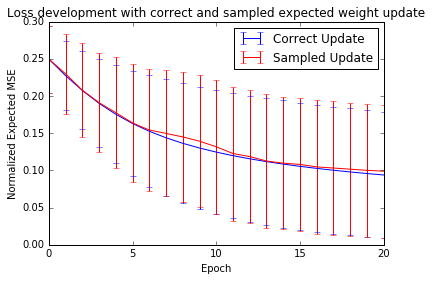

Elapsed time: 0.58 sec.


In [179]:
two_layer_learning(N=100, n_neurons=[1,1], labels=linear_labels, num_epochs=20, sample_size=1, learning_rate=1.0)

Number of networks to train: 100.


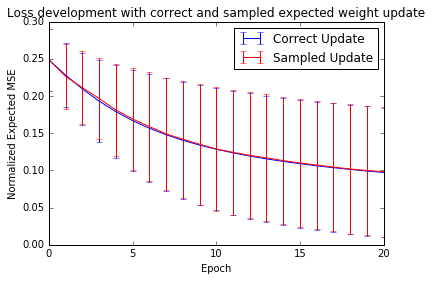

Elapsed time: 1.09 sec.


In [181]:
two_layer_learning(N=100, n_neurons=[1,1], labels=linear_labels, num_epochs=20, sample_size=10, learning_rate=1.0)

Number of networks to train: 100.


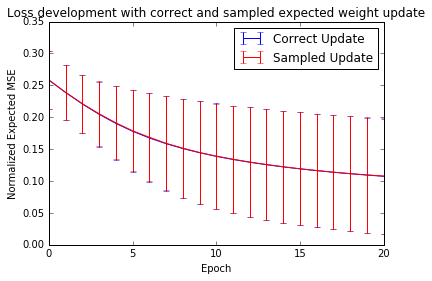

Elapsed time: 4.97 sec.


In [182]:
two_layer_learning(N=100, n_neurons=[1,1], labels=linear_labels, num_epochs=20, sample_size=100, learning_rate=1.0)

Number of networks to train: 100.


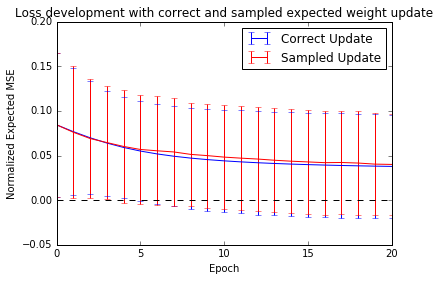

Elapsed time: 0.56 sec.


In [183]:
two_layer_learning(N=100, n_neurons=[1,1], labels=ae_labels, num_epochs=20, sample_size=1, learning_rate=1.0)

Number of networks to train: 100.


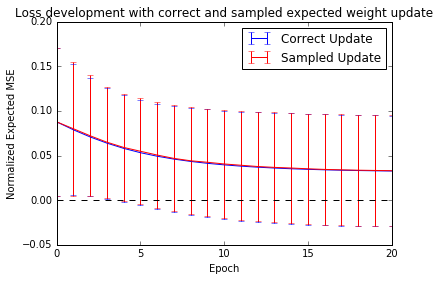

Elapsed time: 1.03 sec.


In [184]:
two_layer_learning(N=100, n_neurons=[1,1], labels=ae_labels, num_epochs=20, sample_size=10, learning_rate=1.0)

Number of networks to train: 100.


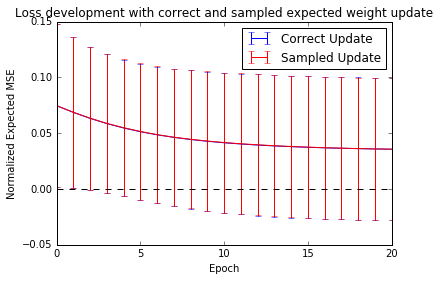

Elapsed time: 4.75 sec.


In [185]:
two_layer_learning(N=100, n_neurons=[1,1], labels=ae_labels, num_epochs=20, sample_size=100, learning_rate=1.0)

### Training n-to-n autoencoders (2-layer)

Here, we train at first 5-to-5 autoencoders and then 10-to-10 autoencoder. We use again the sample sizes 1, 10 and 100. Note, that we now need much better sampling sizes to achieve similar results.

Number of networks to train: 100.


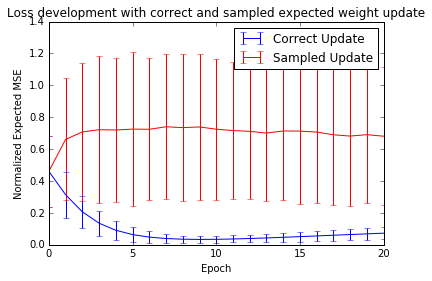

Elapsed time: 0.88 sec.


In [186]:
two_layer_learning(N=100, n_neurons=[5,5], labels=ae_labels, num_epochs=20, sample_size=1, learning_rate=1.0)

Number of networks to train: 100.


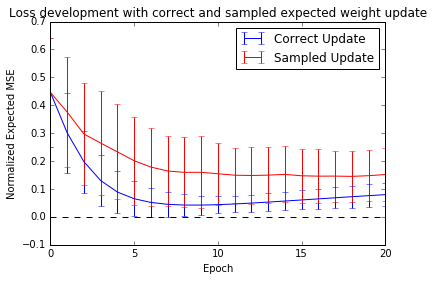

Elapsed time: 1.37 sec.


In [187]:
two_layer_learning(N=100, n_neurons=[5,5], labels=ae_labels, num_epochs=20, sample_size=10, learning_rate=1.0)

Number of networks to train: 100.


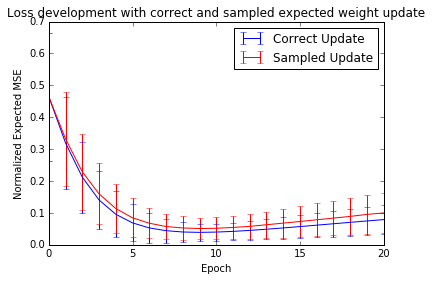

Elapsed time: 5.83 sec.


In [188]:
two_layer_learning(N=100, n_neurons=[5,5], labels=ae_labels, num_epochs=20, sample_size=100, learning_rate=1.0)

Number of networks to train: 100.


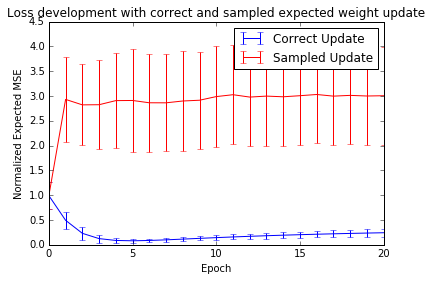

Elapsed time: 6.84 sec.


In [189]:
two_layer_learning(N=100, n_neurons=[10,10], labels=ae_labels, num_epochs=20, sample_size=1, learning_rate=1.0)

Number of networks to train: 100.


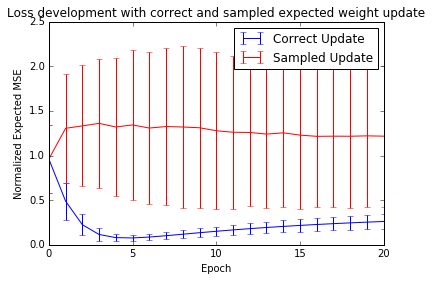

Elapsed time: 7.09 sec.


In [190]:
two_layer_learning(N=100, n_neurons=[10,10], labels=ae_labels, num_epochs=20, sample_size=10, learning_rate=1.0)

Number of networks to train: 100.


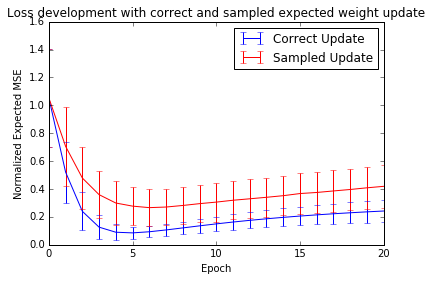

Elapsed time: 11.69 sec.


In [191]:
two_layer_learning(N=100, n_neurons=[10,10], labels=ae_labels, num_epochs=20, sample_size=100, learning_rate=1.0)

### Training of arbitrary n-to-m networks with 0/1 labels

Here are a few more examples to get an intuition of how well the learning rules perform.

Number of networks to train: 100.


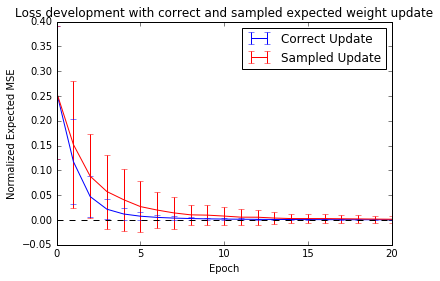

Elapsed time: 3.87 sec.


In [193]:
two_layer_learning(N=100, n_neurons=[10,1], labels=linear_labels, num_epochs=20, sample_size=1, learning_rate=1.0)

Number of networks to train: 100.


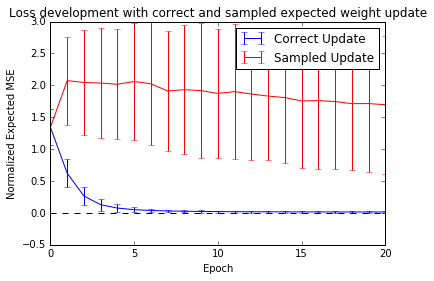

Elapsed time: 3.87 sec.


In [194]:
two_layer_learning(N=100, n_neurons=[10,5], labels=linear_labels, num_epochs=20, sample_size=1, learning_rate=1.0)

Number of networks to train: 100.


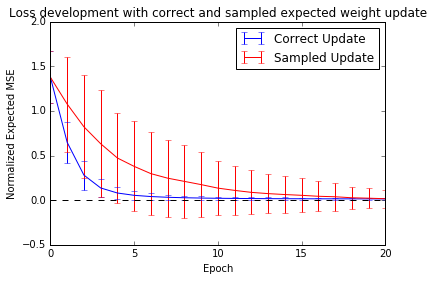

Elapsed time: 4.32 sec.


In [195]:
two_layer_learning(N=100, n_neurons=[10,5], labels=linear_labels, num_epochs=20, sample_size=10, learning_rate=1.0)

Number of networks to train: 100.


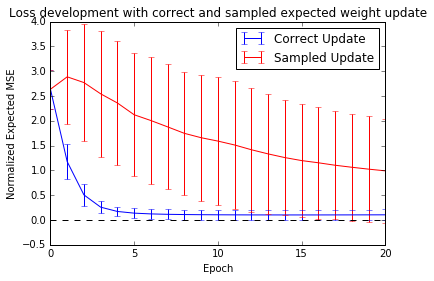

Elapsed time: 7.24 sec.


In [196]:
two_layer_learning(N=100, n_neurons=[10,10], labels=linear_labels, num_epochs=20, sample_size=10, learning_rate=1.0)

Number of networks to train: 100.


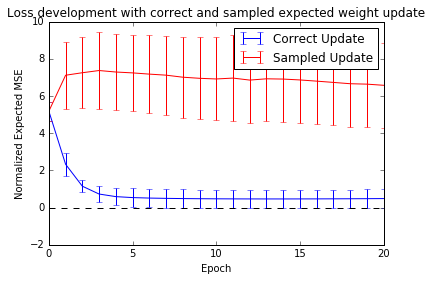

Elapsed time: 21.83 sec.


In [197]:
two_layer_learning(N=100, n_neurons=[10,20], labels=linear_labels, num_epochs=20, sample_size=10, learning_rate=1.0)

Number of networks to train: 100.


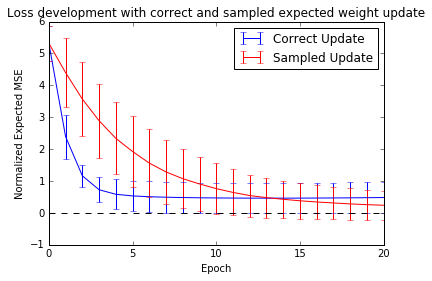

Elapsed time: 26.61 sec.


In [198]:
two_layer_learning(N=100, n_neurons=[10,20], labels=linear_labels, num_epochs=20, sample_size=100, learning_rate=1.0)